This file builds ML datasets with different lags. <br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prep-training-data" data-toc-modified-id="Prep-training-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prep training data</a></span></li><li><span><a href="#Plot-correlation-to-check-for-redundant-features" data-toc-modified-id="Plot-correlation-to-check-for-redundant-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot correlation to check for redundant features</a></span></li><li><span><a href="#Prepare-dataset" data-toc-modified-id="Prepare-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare dataset</a></span></li><li><span><a href="#Inspect-results" data-toc-modified-id="Inspect-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Inspect results</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
import math
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists, drop_database

import jetson_configs as jcfg
from src.ml_helpers.make_ml_dataset import *

In [2]:
current_month = jcfg.current_month
admin_level   = jcfg.admin_level
horizon       = jcfg.horizon

# Configure connection

In [3]:
#We supply our credentials and point to the database we're trying to connect to and
host     = jcfg.sql_host
user     = jcfg.sql_user
password = jcfg.sql_password
database = "jetson"

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}') 

In [4]:
# Load the SQL_magic extension and configure the connection
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

## Prep training data

Format for the data is:

    [ target ]  [3, 12 month own admin lag] [region dummy] [month dummy] [3, 12 month other admin lag] [linear time var] [missing vals]

In [5]:
df = pd.read_sql(f"SELECT * FROM master_{admin_level}", index_col=['date', 'region'], con=engine)

len(df.index.unique().tolist())

2213

## Plot correlation to check for redundant features

In [6]:
old_names = df.columns
new_names = df.columns

new_names = [i.replace("_", " ").title() for i in new_names]

new_names = [i.replace("River ", "Environment - ") + " River Water Level" if "River" in i else i for i in new_names ]
new_names = [i.replace("Awd ", "Health - Acute watery diarrhea/")         if "Awd "  in i else i for i in new_names ]
new_names = [i.replace("Tot ", "Economy - Terms of trade - ")             if "Tot "  in i else i for i in new_names ]
 

names_dict = {
 'Malaria Cases'             : 'Health - Malaria Cases',
 'Measles Cases'             : 'Health - Measles Cases',
 'New Admissions Gam'        : 'Health - New hospital admissions (acute malnutrition)',
 'Cost Of Minimum Basket Cmb': 'Economy - Cost of minimum basket',
 'Incidents'                 : 'Conflict - Incidents',
 'Fatalities'                : 'Conflict - Fatalities',
 'Charcoal50Kg'              : 'Economy - Price of charcoal',
 'Petrol1Litre'              : 'Economy - Price of petrol',
 'Firewoodbundle'            : 'Economy - Price of firewood',
 'Goatlocalquality'          : 'Economy - Price of local goats',
 'Importedredrice1Kg'        : 'Economy - Price of red rice',
 'Maize Prices'              : 'Economy - Price of maize',
 'Waterdrum'                 : 'Economy - Price of water drum',
 'Wheatflour1Kg'             : 'Economy - Price of wheat flour',
 'Redsorghum1Kg'             : 'Economy - Price of red sorghum',
 'Somalishillingtousd'       : 'Economy - Shilling to USD exchange rate',
 'Dailylaborrate'            : "Economy - Daily wage",
 'Distance Driving Hr'       : 'Geography - Avg. driving dist. to other regions (hrs)',
 'Distance Driving Km'       : 'Geography - Avg. driving dist. to other regions (km)',
 'Distance Straight'         : 'Geography - Shortest dist. to other regions',
 'Shared Border'             : 'Geography - # of bordering regions',
 'Rainfall'                  : 'Environment - Rainfall',
 'Vegetation Cover Ndvi'     : 'Environment - Vegetation cover (NDVI)',
}

new_names = [names_dict[i] if i in names_dict.keys() else i for i in new_names ]

names_dict = {xy[0]: xy[1] for xy in zip(old_names,new_names)}

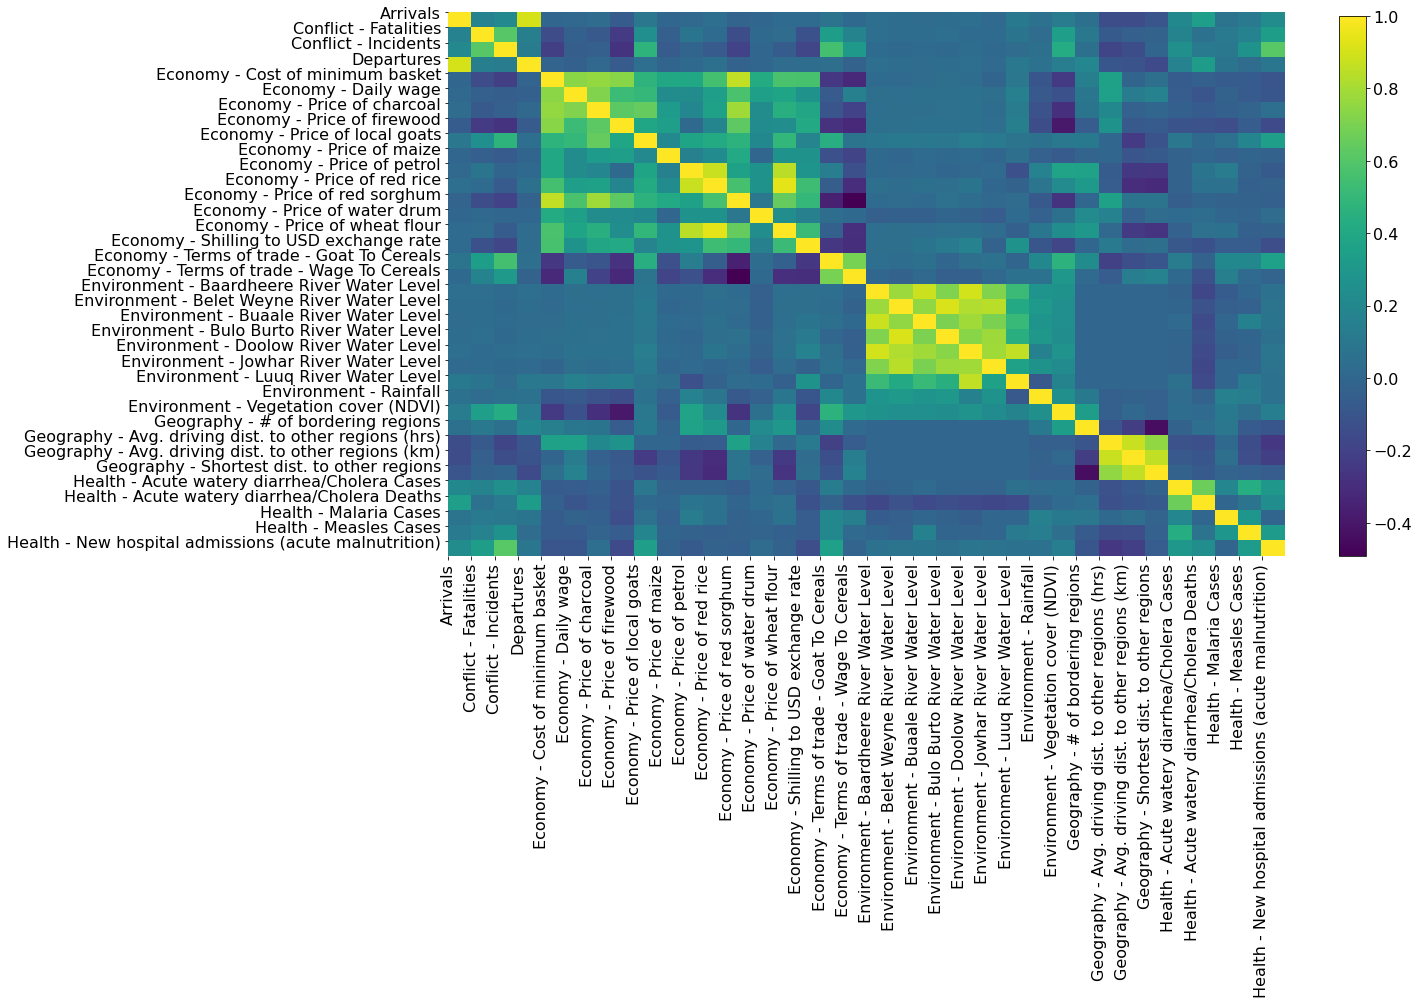

In [7]:
fig,ax = plt.subplots(1,1, figsize=[15,10])

# Rename the columns
plot_df = df.copy()
plot_df.columns = [names_dict[i] for i in plot_df.columns]
plot_df.sort_index(axis=1, inplace=True)

# Make the heatmap
sns.heatmap(plot_df.corr(), ax=ax, cbar=None, cmap='viridis')
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(plot_df.columns, fontsize=16)
ax.set_yticklabels(plot_df.columns, fontsize=16)

# Colorbar
im = plt.gca().get_children()[0]    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.125, 0.025, 0.75], )
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)

plt.savefig("figures/corrplot.png", dpi=100, bbox_inches="tight")

## Prepare dataset

In [8]:
learn_df = make_ml_features(current_month, horizon, admin_level, sql_engine=engine)

Dropped entirely missing columns:  []
Dropped duplicate columns:  ['miss_incidents', 'miss_malaria_cases', 'miss_measles_cases', 'miss_vegetation_cover_ndvi']


## Inspect results

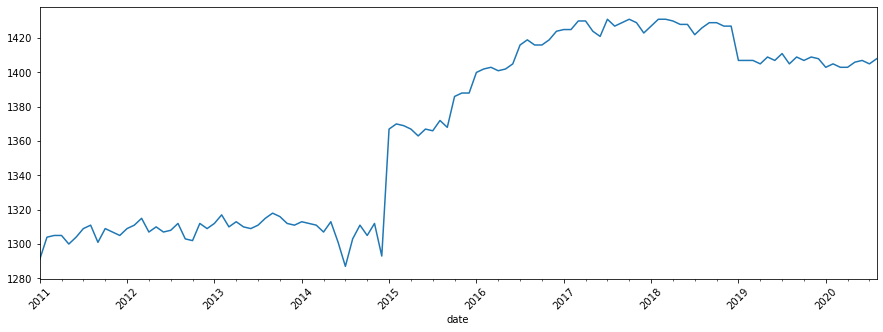

In [9]:
# Check one dataframe for missing values
learn_df = pd.read_csv(f'ml/input_data/learn_df_admin1.csv', index_col=['region', 'date'], parse_dates=['date'])
learn_df.unstack(level='date').count().unstack(level=1).sum().plot(figsize=[15,5], rot=45)

In [10]:
# Check for data leakage
for c in learn_df.columns:
    if "arrivals" not in c:
        assert( (learn_df.arrivals.isna() | (learn_df[c]==learn_df['arrivals'])).all() == False)

In [11]:
# Identify months with most missing observations
learn_df.unstack(level='date').count().unstack(level=1).sum().sort_values().head()

date
2014-07-01    1287
2011-01-01    1291
2014-12-01    1293
2011-05-01    1300
2014-06-01    1301
dtype: int64

In [12]:
# Identify variables with most missing observations
learn_df.count().sort_values().head(10)

awd_cholera_deaths      540
new_admissions_gam     1008
river_doolow           1062
awd_cholera_cases      1224
measles_cases          1224
malaria_cases          1224
departures             1674
somalishillingtousd    1725
maize_prices           1771
arrivals               1789
dtype: int64

In [13]:
# Check total number of dates in the dataset
len(learn_df.index.get_level_values('date').unique())

116